# Ch 7 - Markov Chain Monte Carlo

MCMC is most useful when the methods outlines in Ch 5 and Ch 6 are not appropriate. For example, if we have a model which does not have an easily solvable analytic posterior (like the method in Ch 6) and which is also not easy to solve by exhaustively sampling over (what we do in Ch 5) possibly because the model has many parameters.

### When to use:
There are a couple of things that need to be true for MCMC to work well:
1. The prior distribution is easily evaluated - i.e. to borrow from the coin flip example, that for a specific $\theta$ we can find $p(\theta)$ easily with a computer.
2. That the liklihood function $p(D \, | \, \theta)$ (the probability of the observation D given the parameter $\theta$) is computable for any specified values of D and $\theta$.

### What it gives us:
MCMC generates lots of $\theta$ values sampled from the posterior, and this allows us to estimate lots of things like central tendency, Highest Density Interval (HDI) and the like. In essence, we approximate the posterior with a large representative sample.

### So how do we sample a lot of representative points from the posterior?
#### Intuition
Imagine we are on a linear archipelago, and we want to visit each island proportionally to its population. However also imagine that we don't know the population of all of the islands, or even how many islands there are. All we know is the population of our island and all adjacent islands. 

Let's say we decide to act in accordance with the following algorithm (The Metropolis Algorithm):
- Choose which island to consider moving to. If there are more than one adjacent islands, simply pick which one to make the 'prospective next move' uniformly. E.g. if there are two other islands, irrespective of their populations, just flip a coin.
- If the prospective island has a population that is **larger than or the same as** the current one, move to it.
- If the prospective island has a smaller population than the current one, move to it with a probability of p = $\frac{\textrm{population of prospective island}}{\textrm{population of current island}}$. This can be achieved by just generating a random number. If the number is sampler than p, move islands.
- Imagine that there are islands at each of the edges with a population of 0.

If we do this, in the long run, we will satisfy our goal of spending a proportional amount of time on each island.

### Example of Metropolis Algorithm

In [1]:
#Example code:
island_pop = c(0, 10, 5, 6, 7, 8, 9, 10, 0)

#number of iterations to run
iterations = 100000

#Specifiy starting position
curr_pos = sample(2:length(island_pop)-1, 1)

metropolis = function(dist, pos){
    curr_pop = dist[pos]
    offset = sample(c(-1, 1), 1)
    prosp_pop = dist[pos + offset]
    
    #test for moving:
    pos = pos + (runif(1, 0, 1) < min(1, prosp_pop / curr_pop)) * offset
    
    return(pos)
}
    
result = rep(0, length(island_pop))
for (i in seq(iterations)){
    curr_pos = metropolis(island_pop, curr_pos)
    result[curr_pos] = result[curr_pos] + 1
}


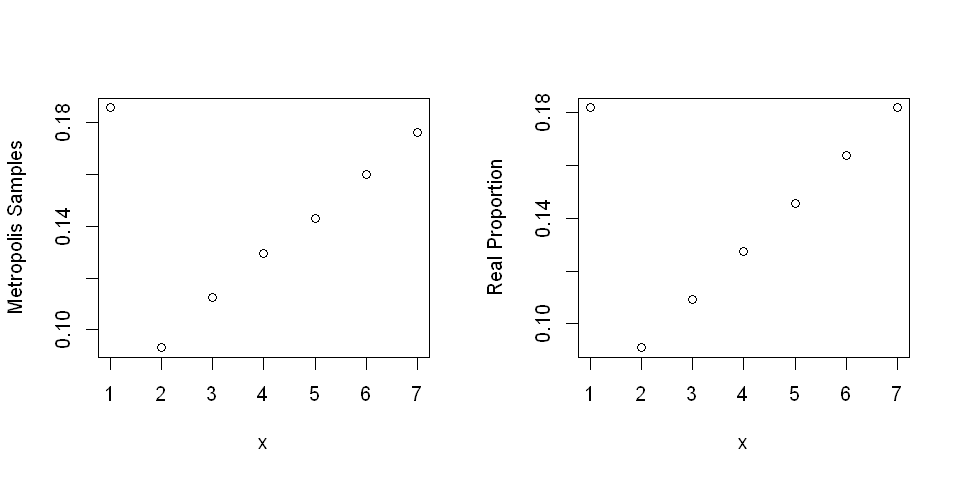

In [2]:
#plot the result out
library(ggplot2)
library(repr)
options(repr.plot.width=8, repr.plot.height=4)

x = seq(length(island_pop) - 2)
y_m = result[2:(length(island_pop)-1)]
y_real = island_pop[2:(length(island_pop)-1)]

#Formatting
par(mfrow=c(1,2))

plot(x, y_m / sum(y_m), ylab = "Metropolis Samples")
plot(x, y_real / sum(y_real), ylab = "Real Proportion")

### Why do I care?
Well, in the case of working out a posterior, we generally use Bayes Rule:
$$p(\theta \, | \, D) = \frac{p(D \, | \, \theta)p(\theta)}{p(D)}$$
Recall that the reason this can be hard is if $p(D)$ isn't solvable analytically - this forces us to create a grid of sample $\theta$s and brute force through the problem. However, as we can see from the above example, the Metropolis algorithm gives us a representative sample from the posterior (which is proportional to $p(D \, | \, \theta)p(\theta)$ without actually needing to normalize. I.e. we don't even need to work out $p(D)$. 

### Computational Proof
Say we have three states, with the following respective proportional "importances": [6, 3, 4]

Let's use the Metropolis Algorithm and MCMC to find the equilibrium:

Note that the graph we are traversing here is a fully connected graph with non-integer values. The Metropolis Algorithm will work here too.

In [3]:
#Proof (computational):
states = c(6,3,4.5,8)

###################################################################
#Generate a transition matrix from the algorithm above.

#Create empty matrix

get_state_trans_matrix = function(states){
    trans_matrix = c()

    #populate the matrix
    for (to in seq(length(states))){
        for (from in seq(length(states))){
            if (from == to){
                res = (1 - (1/(length(states) - 1)) * sum(sapply(states[-from], 
                                                        function(x) min(1, (x/states[from])))))
                trans_matrix = append(trans_matrix, res)                            
            }
            else{
                res = (1/(length(states) - 1)) *  min(1, (states[to]/states[from]))
                trans_matrix = append(trans_matrix, res)
            }
        }
    }
    return(matrix(trans_matrix, length(states), length(states)))
}
trans_matrix = get_state_trans_matrix(states)
                                                                 
trans_matrix

0.2500000,0.1666667,0.2500000,0.3333333
0.3333333,0.0000000,0.3333333,0.3333333
0.3333333,0.2222222,0.1111111,0.3333333
0.2500000,0.1250000,0.1875000,0.4375000


In [4]:
#Specify number of iterations
iterations = 1000

#Get random initial state:
curr_state = matrix(0, 1, length(states))
curr_state[sample(seq(length(states)), 1)] = 1

#iterate out over the state transition matrix:
for (i in seq(iterations)){
    curr_state = curr_state %*% trans_matrix
}

curr_state

0.2790698,0.1395349,0.2093023,0.372093


In [5]:
states / sum(states)

[1] 0.2790698 0.1395349 0.2093023 0.3720930

^ Yep it matches!

### The more general Metropolis algorithm
We have some target distribution $P(\theta)$ over some multidimensional continuous parameter space, from which we would like to generate representative samples. $P(\theta)$ need not be normalized (although it must be non-negative), and we must be able to calculate $P(\theta)$ for any candidate value of $\theta$. In typical applications, $P(\theta)$ is the un-normalized product of the likelihood and the prior on $\theta$.

##### How do we work out where to "step" next in a continuous case?
We step according to some 'proposal distribution' (e.g. a normal distribution). Taking the current position as the mean (initially we must choose somewhere that $P(\theta)$ is non-zero), we sample some other point in the paramter space determined at random by drawing from out proposal distribution, and move our mean to it if the Metropolis condition is met (auto-move if it's larger, move probabilistically if not).

### Metropolis Sampling with Coin Flip example:

Recall that:
$$p(\theta \, | \, z, N) = \frac{\theta^{(a + z - 1)} (1-\theta)^{(N-z+b-1)}}{B(z+a, N-z+b)}$$

Or separated out into its components:

$$p(\theta \, | \, z, N) = \theta^{n} (1-\theta)^{(N-z)} \; \frac{\theta^{(a - 1)} (1-\theta)^{(b-1)}}{B(a, b)}$$
$$\textrm{posterior} = \textrm{Bernoulli likelihood} \times \textrm{Beta prior}$$

where:  
N = number of events (coin tosses)  
z = number of successes (heads)
a = prior a
b = prior b

Since we don't need to normalize for the Metropolis algorithm, we can ignore the denominator. Thus, our posterior distribution is:
$$\theta^{(a + z - 1)} (1-\theta)^{(N-z+b-1)}$$
OR (functionally equivalent):
$$\theta^{n} (1-\theta)^{(N-z)} \; \textrm{beta}(\theta, a, b)$$
Let's compare the results from solving analytically (using the Beta distribution) and with Monte Carlo (using the Metropolis algorithm).

In [6]:
#Here are our empirical results
N = 20
z = 15

#Specify our prior
a_prior = 10
b_prior = 10

#######################################################
# BETA
#######################################################

#Range of x values to sample over:
x = seq(0, 1, 0.01)

#Generate Distribution
posterior_beta = dbeta(x, (N + a_prior), (N - z + b_prior))

#######################################################
# METROPOLIS
#######################################################

#Specify number of iterationsf
iter = 10000

get_posterior = function(theta, N, z, a_prior, b_prior){
    #Bernoulli likelihood * beta prior 
    return(theta ** z * (1-theta) ** (N - z) * dbeta(theta, a_prior, b_prior))
    
    #Note this should function the same way if we simply encode the prior 
    #and evidence in a bernoulli series
}

N_post = N + a_prior + b_prior
z_post = z + a_prior

#First grab a random non-zero theta:
while(1){
    theta_curr = runif(1, 0, 1)
    if (get_posterior(theta_curr, N, z, a_prior, b_prior) > 0){
        result = c(theta_curr)
        break
    }
}

#Now run through the Metropolis algorithm for the given number of iterations:

sigma = 0.2

for (i in seq(iter)){
    #Generate new point (within the acceptable range):
    while(1){
        theta_next = rnorm(1, theta_curr, sigma)
        if ((1 >= theta_next) & (theta_next >= 0)){
            break
        }
    }
    #Metropolis:
    result = append(result, theta_curr)
    if (runif(1,0,1) < min(1, (get_posterior(theta_next, N, z, a_prior, b_prior) / 
                               get_posterior(theta_curr, N, z, a_prior, b_prior)))){
        theta_curr = theta_next
    }
    result = append(result, theta_curr)
}

Warning message in plot.xy(xy, type, ...):
"plot type 'line' will be truncated to first character"

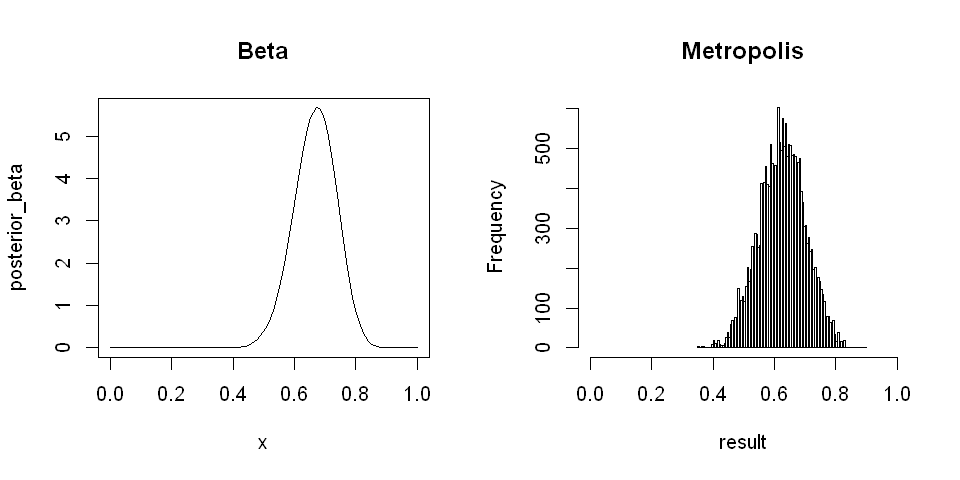

In [7]:
library(repr)
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
plot(x, posterior_beta, type = "line", main = "Beta")
hist(result, breaks = 100, xlim = c(0,1), main = "Metropolis")

#### The effect of sigma
It's worth noting that there are tradoffs with using different sigma vales for our proposal distribution. Small sigmas will converge slowly, large sigmas will converge quickly, and medium sigmas will converge at a medium pace and be very efficient (i.e. iterations of the metropolis algorithm will be more efffectively turned into 'moves' resulting in a higher effective sample size).

##### What if we want to sample from a distribution with more than one parameter?
For that we use Gibbs sampling.